In [1]:
import pandas as pd
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import seaborn as sns                                  # Make the plots nicer to look at
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import matplotlib.ticker as tck
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy.signal import find_peaks
from scipy import stats
import glob
import os

sys.path.append('External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

In [2]:
#Load files
Pen = pd.read_csv (r'CSV/Pendul.csv', sep=";")

Pen_data1 = pd.read_csv (r'Data/Pendul/Malthe1.dat', sep='\t')
Pen_data2 = pd.read_csv (r'Data/Pendul/Mads1.dat', sep='\t')
Pen_data3 = pd.read_csv (r'Data/Pendul/Niels1.dat', sep='\t')
Pen_data4 = pd.read_csv (r'Data/Pendul/Emilie1.dat', sep='\t')

Pen_data = []
Pen_data.append(Pen_data1)
Pen_data.append(Pen_data2)
Pen_data.append(Pen_data3)
Pen_data.append(Pen_data4)

In [3]:
#PDF's
def line(x,a,b):
    """Just a line"""
    return a*x+b

def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def exp_pdf(x, a, V0, s0):
    """Exponential"""
    return 0.5 * a * x**2 + V0 * x + s0

In [4]:
cal_avg_error(Pen)[0]

NameError: name 'cal_avg_error' is not defined

In [5]:
# Weighted Error and Average
def cal_avg_error(df):
    df = df.append(pd.Series(1, index=df.columns), ignore_index=True) #adds row
    Chi2, Chi2_prob, column_names = [], [], []
    for i in range(int(len(df.T)/2)):
        # Weighted Error and Average
        df.iloc[-1, i*2], df.iloc[-1, i*2+1], chi2, chi2_prob = w_mean(df.iloc[:-1, i*2], df.iloc[:-1, i*2+1])
        Chi2.append(chi2), Chi2_prob.append(chi2_prob), column_names.append(df.columns[i*2])
        
    return df, Chi2, Chi2_prob, column_names

def w_mean(dat,err):
    weight = 0
    for i in err:
        if i == 0:
            weight = 1
        else:
            weight += (1/i)**2

    mean_weighted = 0
    for i in range(len(dat)):
        mean_weighted += (float(dat[i])*(1/float(err[i]))**2)/weight

    err_weighted = np.sqrt(1/weight)
    
    Chi2 = np.sum(((np.array(dat)-mean_weighted)/np.array(err))**2)
    Chi2_prob = stats.chi2.sf(Chi2, len(dat)-1)
        
    return mean_weighted, err_weighted, Chi2, Chi2_prob

In [6]:
def main_fit(data, Nbins=5, xmin=None, xmax=None, figsize=None, 
             plt_first=False, plt_hist=False, plt_final=False, plt_res=True):
    
    T_values, T_errors = [], []
    
    for i in range(len(data)):
        #DATA SETUP:
        data_x, data_y = data[i][xmin:xmax].Lab, data[i][xmin:xmax].Time
        
        #FITTING FUCNTIONENS:
        minuit_frist_fit  = frist_fit(data_x, data_y) #FIRST FIT
        minuit_hist, hist_likeho, res, x_res, counts  = histogram_fit(data_x, data_y, minuit_frist_fit, Nbins) #HISTOGRAM FIT
        minuit_last_fit, last_errors, last_Chi2 = last_fit(data_x, data_y, minuit_hist[1]) #LAST FIT
        
        #PLOTTING FUNCTIONS:
        if plt_first == True:
            plot_line(data_x, data_y, minuit_frist_fit, figsize) #FRIST PLOT

        if plt_hist == True:
            plot_hist(data_x, data_y, res, minuit_hist, Nbins, figsize) #HISTOGRAM PLOT
            
        if plt_final == True:
            plot_line(data_x, data_y, minuit_last_fit, figsize) #FINAL PLOT
        
        if plt_res == True:
            plot_res(data_x, data_y, res, minuit_last_fit, last_errors, 
                     minuit_hist, hist_likeho, last_Chi2, Nbins, x_res, counts, figsize) #RESIDUAL PLOT
            
        T_values.append(minuit_last_fit), T_errors.append(last_errors)
        
    #EXPORTING DATA: 
    L, L_error = L_cal()
    T, T_error, T_Chi2, T_Chi2_prob = T_cal(T_values, T_errors)
    g, g_error = g_cal(T, T_error, L, L_error)
    
    _, Chi2, Chi2_prob, column_names = cal_avg_error(Pen)
    
    print("L =",L,u"\u00B1",L_error,"mm")
    print("T =",T,u"\u00B1",T_error,"s")
    print("g =",g/1000,u"\u00B1",g_error/1000,"m/s^2\n")
    
    print('T : Chi2 = ', T_Chi2, ', Chi2_prob:', T_Chi2_prob)
    
    for i in range(len(Chi2)):
        print(column_names[i], ': Chi2 = ', Chi2[i], ', Chi2_prob:', Chi2_prob[i])
    
    return

In [21]:
def frist_fit(data_x, data_y):
    # Defining Chi2 calculation:
    chi2fit = Chi2Regression(line, data_x, data_y)

    minuit_chi2 = Minuit(chi2fit, a=0.1, b=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()
    return minuit_chi2.values[:]


def histogram_fit(data_x, data_y, minuit_fit, Nbins):
    res = data_y - line(data_x, *minuit_fit)
    
    counts, bin_edges = np.histogram(res, bins=Nbins, range=(min(res), max(res)))
    x_res = (bin_edges[1:] + bin_edges[:-1])/2
 
    # Defining unbind likelyhood calculation:
    #ullhfit = UnbinnedLH(gauss_pdf, x_res, counts)
    ullhfit = UnbinnedLH(gauss_pdf, res)
        
    minuit_ullh = Minuit(ullhfit, mu=0, sigma=res.std())
    minuit_ullh.errordef = 0.5   
    minuit_ullh.migrad()
    return minuit_ullh.values[:], minuit_ullh.fval, res, x_res, counts


def last_fit(data_x, data_y, data_y_error):
    # Defining Chi2 calculation:
    chi2fit = Chi2Regression(line, data_x, data_y, data_y_error)

    minuit_chi2 = Minuit(chi2fit, a=0.1, b=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()
    
    return minuit_chi2.values[:], minuit_chi2.errors[:], minuit_chi2.fval


def L_cal():
    x = cal_avg_error(Pen)[0][-1:]
    L = x.iloc[0,0] -x.iloc[0,2]*0.5 + x.iloc[0,4]
    L_err = np.sqrt(x.iloc[0,1]**2 + 0.25*x.iloc[0,3]**2 + x.iloc[0,5]**2)
    return L, L_err
    
def T_cal(data_values, data_erros):
    return w_mean(np.array(data_values)[:,0], np.array(data_erros)[:,0])


def g_cal(T, T_err, L, L_err):
    g = L * (2*np.pi/T)**2
    g_err = np.sqrt(((2*np.pi/T)**2)**2 * L_err**2 + (-8*L*(np.pi**2)/T**3)**2 * T_err**2)
    return g,g_err


def plot_line(data_x, data_y, minuit_fit, figsize):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.set_ylabel('lab time [s]')
    ax.set_xlabel('lab nummer')
    ax.set_title(f'lab timer/numer plot')

    plt.scatter(data_x, data_y)
    ax.plot(data_x, line(data_x, *minuit_fit), '-') 
    return plt.show()


def plot_hist(data_x, data_y, res, minuit_fit, Nbins, figsize):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.set_ylabel('lab time [s]')
    ax.set_xlabel('lab nummer')
    ax.set_title(f'lab timer/numer plot')

    x_axis = np.linspace(min(res), max(res), 1000)
    ax.hist(res, bins=Nbins, range=(min(res), max(res)), histtype='step', linewidth=2, color='red')
    ax.plot(x_axis, gauss_pdf(x_axis, *minuit_fit), '-b') 
    return plt.show()
    

def plot_res(data_x, data_y, res, minuit_fit, minuit_error, minuit_res_fit, Like,
             Chi2, Nbins, x_res, counts, figsize):
    sigma = minuit_res_fit[1]
    x_axis = np.linspace(min(res), max(res), 1000)
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot()

    ax1.set_ylabel('Time elapsed (s)')
    ax1.set_xlabel('Timing measurement number')

    #Adding exstra y-axis:
    ax2 = ax1.twinx()
    ax2.set_ylabel('Residuals (s)')
    ax2.yaxis.set_minor_locator(tck.AutoMinorLocator(10))
    
    #Embeded fig:
    ins = ax1.inset_axes([0.03, 0.65, 0.35, 0.3])
    #ins.hist(res, bins=Nbins, range=(min(res), max(res)), histtype='step', linewidth=2)
    ins.plot(x_axis, gauss_pdf(x_axis, *minuit_res_fit), '-', color='red') 
    ins.yaxis.tick_right()
    ins.errorbar(x_res, counts, fmt='none', yerr=np.sqrt(counts))
    ins.plot(x_res,counts, '.', color='black')
    
    ins.set_xlabel('Residuals (s)')
    ins.set_ylabel('Counts')
    ins.yaxis.set_label_position("right")
    
    #Plotting main data:
    ax1.plot(data_x, data_y, '.', color='black')
    ax1.plot(data_x, line(data_x, *minuit_fit)) 

    #Plotting residuals data:
    ax2.plot(data_x, res, '.', color='black')
    ax2.errorbar(data_x, res, fmt='none', yerr=res.std(), color='red')
    ax2.axhline(res.mean(), color='grey', linestyle='-')

    ax2.axhline(res.mean() + sigma, color='grey', linestyle=':')
    ax2.axhline(res.mean() - sigma, color='grey', linestyle=':')
    print(sigma)
    print(minuit_fit[0])
    #Adding legend (and cal of Chi2_prob)
    Chi2_prob = stats.chi2.sf(Chi2, len(data_x)-2)
    Like_prob = stats.chi2.sf(Like, len(data_x)-2)
    ax2.text(21, 0.28, 
             #text in plot:
             f'Periode = {minuit_fit[0]:.4f} +/- {minuit_error[0]:.4f} s \n'
             f'Chi\u00b2 = {Chi2:.2f} \n'
             f'Chi\u00b2 probability = {Chi2_prob:.2f} \n\n'
             f'Residual: \nLikelihood = {Like:.2f} \n'
            )
    
    #Setting limits:
    ax1.set_ylim([min(data_y)-30, max(data_y)+10])
    ax2.set_ylim([-0.2, 1.2])

    return plt.show()

0.06018630981126012
2.8513676354677564


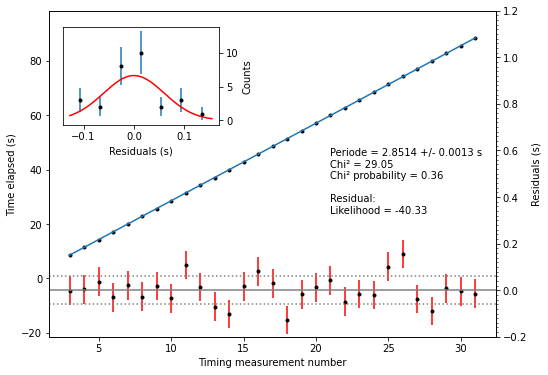

0.04594029270278
2.853868075639805


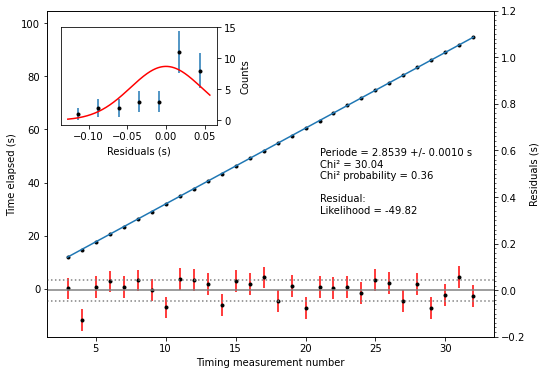

0.027250213606678834
2.8538012096774024


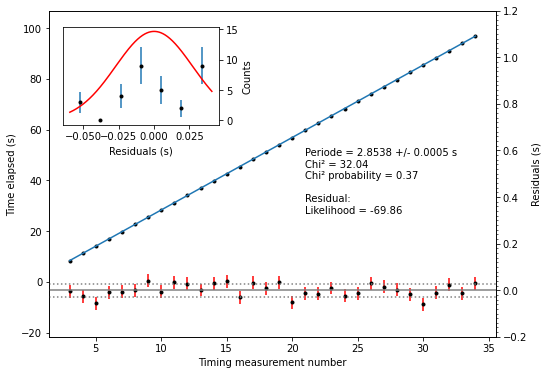

0.034322975630740264
2.8550334677418614


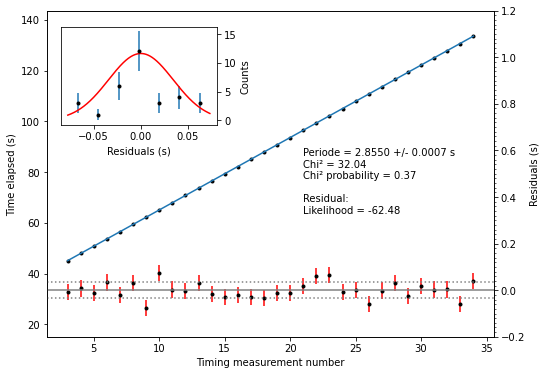

L = 2020.3545015838931 ± 0.16320806505579677 mm
T = 2.854006197154837 ± 0.00036238835404036777 s
g = 9.792137265294743 ± 0.002609501577696538 m/s^2

T : Chi2 =  6.519895771022922 , Chi2_prob: 0.08888115766627741
Snorlængde_mm : Chi2 =  3.2573046018996004 , Chi2_prob: 0.3536293925162113
Lod_mm : Chi2 =  7.646576839037943 , Chi2_prob: 0.05390949443289831
Lod_med_krog_mm : Chi2 =  54.02728325734388 , Chi2_prob: 1.1071269297066305e-11
Krog_mm : Chi2 =  2.3370499999999826e-06 , Chi2_prob: 0.999999999049788


In [22]:
main_fit(Pen_data, Nbins=7, xmin=2, plt_res=True, xmax=None, figsize=(8, 6))